In [12]:
import pandas as pd
import numpy as np
import csv
import os
import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import xarray as xr
import ftplib
import re
import shapefile as shp
import geopandas as gpd

def at(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [at(c) for c in re.split(r'(\d+)', text)]

list_arg=["ARS%.2d" % i for i in range(1,121)]

# Enter Date 
Enter_Date='20210613'  ##format "YYMMDD"
date1=pd.to_datetime(Enter_Date)
date2=date1+pd.Timedelta(days=1)
date3=date1-pd.Timedelta(days=1)
# date3.strftime('%d-%B,%Y %H:%M:%S'),date1.strftime('%d-%B,%Y %H:%M:%S'),date2.strftime('%d-%B,%Y %H:%M:%S')

# Data Download from FTP Server

In [13]:
## Login to ftp server

ftp =ftplib.FTP('103.251.184.105', 'cellnet', '5%1E8bD%Db@')

### Data downloading from FTP
for arg in list_arg[0:120]:
    ftp =ftplib.FTP('103.251.184.105', 'cellnet', '5%1E8bD%Db@')
    ftp.cwd('/'+arg+'/')          ### Server dir change

#     os.chdir('D:/DATA/ARG/'+arg)   ### Desktop Dir Change
    os.chdir('/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/'+arg)

    nlst=ftp.nlst()
    nlst.sort(key=natural_keys)
    nlst11=pd.Series(nlst)
    nlst12=nlst11[(nlst11.str.contains(arg+'_'+date1.strftime('%y%m%d'))) |
                  (nlst11.str.contains(arg+'_'+date2.strftime('%y%m%d'))) |
                  (nlst11.str.contains(arg+'_'+date3.strftime('%y%m%d'))) ]
                  
    for filename in nlst12:                ## last '[n]' files doenload
        with open(filename,'wb') as file:
            ftp.retrbinary(f'RETR {filename}',file.write)
#     print(arg)
ftp.close()

In [4]:
# nlst11=pd.Series(nlst)
# nlst12=nlst11[nlst11.str.contains('ARS01_210601') | nlst11.str.contains('ARS01_210602') ]
# nlst12

In [5]:
# files.sort(key=os.path.getmtime)
# print("\n".join(files))

In [15]:
for kk in range(0,120):
    files11=pd.Series(glob.glob('/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/'+list_arg[kk]+'/*.txt'))
    files=files11[(files11.str.contains(list_arg[kk]+'_'+date1.strftime('%y%m%d'))) | 
                  (files11.str.contains(list_arg[kk]+'_'+date2.strftime('%y%m%d'))) |
                  (files11.str.contains(list_arg[kk]+'_'+date3.strftime('%y%m%d')))].values
    
    data=[]
    for j in range(len(files)):
        
#         print(files[j])
        rs_day=[]
        with open(files[j], 'r') as csvfile:
    #         reader = csv.reader(csvfile, delimiter='\t')
            reader = csv.reader(x.replace('\0', '') for x in csvfile)
            for row in reader:
                if (len(row) == 0):
                    continue
                rs_day.append(row)
        rs_data=pd.DataFrame(rs_day)
        
        if(len(rs_data))>5:
            
            date_index=rs_data[rs_data[0].str.startswith('DATE')].index
            date_index=date_index.insert(len(date_index)+1,rs_data.index[-1])
            date=pd.DataFrame(list(rs_data[rs_data[0].str.startswith('DATE')][0].str.split('=')))[1]
            time=pd.DataFrame(list(rs_data[rs_data[0].str.startswith('TIME')][0].str.split('=')))[1]
            dtime=pd.to_datetime(date+time,format='%d/%m/%y%H:%M:%S')-pd.Timedelta(minutes=1)

            ss=pd.DataFrame(list(rs_data[(rs_data[0].str.startswith('Rain'))&(rs_data[1].str.startswith('mm'))].iloc[:,1].str.split(':')))
            dd=[]
            for i in range(len(date_index)-1):
#                 count=rs_data[date_index[i]:date_index[i+1]+1][0].str.startswith('Rain,mm').sum()
                temp=rs_data[date_index[i]:date_index[i+1]+1]
                count=((temp[0].str.startswith('Rain'))&(temp[1].str.startswith('mm'))).sum()
                dd.extend(pd.date_range(dtime[i], periods = count, freq='-1Min')[::-1])

            if (len(ss) == 0):
                    continue
#             if len(ss)<0:
            ss['Date']=dd
            data.extend(ss[['Date',1]].values)
        
    arg_data=pd.DataFrame(data,columns=['Date','Rain_mm'])
    arg_data=arg_data.replace({'':np.nan,' ':np.nan}).dropna().reset_index(drop=True)
    arg_data=arg_data[~arg_data.Rain_mm.str.contains("IMEI")].reset_index(drop=True)
    arg_data['Rain_mm']=arg_data['Rain_mm'].astype(float)
    arg_data=arg_data.sort_values(by=['Date'])
    arg_data.loc[((arg_data['Rain_mm']*10)%2)!=0,['Rain_mm']]=arg_data.loc[((arg_data['Rain_mm']*10)%2)!=0]['Rain_mm']-0.1
#     arg_data.to_csv()
    vars()[list_arg[kk]]=arg_data.copy()
#     print(list_arg[kk])

In [16]:
# q1=arg_data.set_index('Date').to_xarray()
# q1.to_netcdf('D:/DATA/ARG/'+list_arg[kk]+'/'+arg_data.iloc[0,0].strftime('%Y%m%d%H%M%S.nc'))

In [17]:
# ##### Error Detection/Identification ###
# for x in  range(len(arg_data['Rain_mm'])):#.str.strip())):
#     print(float(arg_data['Rain_mm'][x]),x)

In [18]:
def get_gap(mwr1):
    x1=[]
    for kk in range(len(mwr1)-1):
        if (mwr1['Date'][kk+1]-mwr1['Date'][kk])>=datetime.timedelta(minutes=3):
            x1.append(mwr1['Date'][kk]+datetime.timedelta(seconds=1))
            x1.append(mwr1['Date'][kk+1]-datetime.timedelta(seconds=1))

    x2=pd.DataFrame({'Date':x1})
    df2=mwr1.append(x2, ignore_index=True)
    df2=df2.sort_values(by='Date',ascending=True)

    return df2

In [19]:
# Find one day accumulated rain .......... find top 10 ARG ##
max_rf=[]
for arg in list_arg:
#     print(arg)
#     vars()[arg+'_arg']=vars()[arg][vars()[arg]['Date'].between(pd.to_datetime('20210601 0:0:0',format='%Y%m%d %H:%M:%S'),
#                                                               pd.to_datetime('20210602 23:59:59',format='%Y%m%d %H:%M:%S'))]
    vars()[arg+'_arg']=vars()[arg][vars()[arg]['Date'].between(date1,date2)]
    if (len(vars()[arg+'_arg'])==0):
        max_rf.append(np.nan)
        continue
        
    max_rf.append(vars()[arg+'_arg']['Rain_mm'].iloc[-1]-vars()[arg+'_arg']['Rain_mm'].iloc[0])
#     max_rf.append((vars()[arg+'_arg']['Rain_mm']-vars()[arg+'_arg']['Rain_mm'].iloc[0]).max())
    vars()[arg+'_arg']['Rain_mm']=vars()[arg+'_arg']['Rain_mm']-vars()[arg+'_arg']['Rain_mm'].iloc[0] ## substract old count
    vars()[arg+'_arg'].reset_index(drop=True,inplace=True)
    vars()[arg+'_arg']=get_gap(vars()[arg+'_arg'])
#     print(arg)
# top_10arg=pd.DataFrame({'ARG':(pd.Series(list_arg)+'_arg'),'max_rf':max_rf}).sort_values(by=['max_rf'],ascending=False)['ARG'][:10].values
active_rg=pd.DataFrame({'ARG':(pd.Series(list_arg)+'_arg'),'max_rf':max_rf}).sort_values(by=['max_rf'],ascending=False).dropna()['ARG'].values

<ipython-input-19-4f82ad617af0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars()[arg+'_arg']['Rain_mm']=vars()[arg+'_arg']['Rain_mm']-vars()[arg+'_arg']['Rain_mm'].iloc[0] ## substract old count


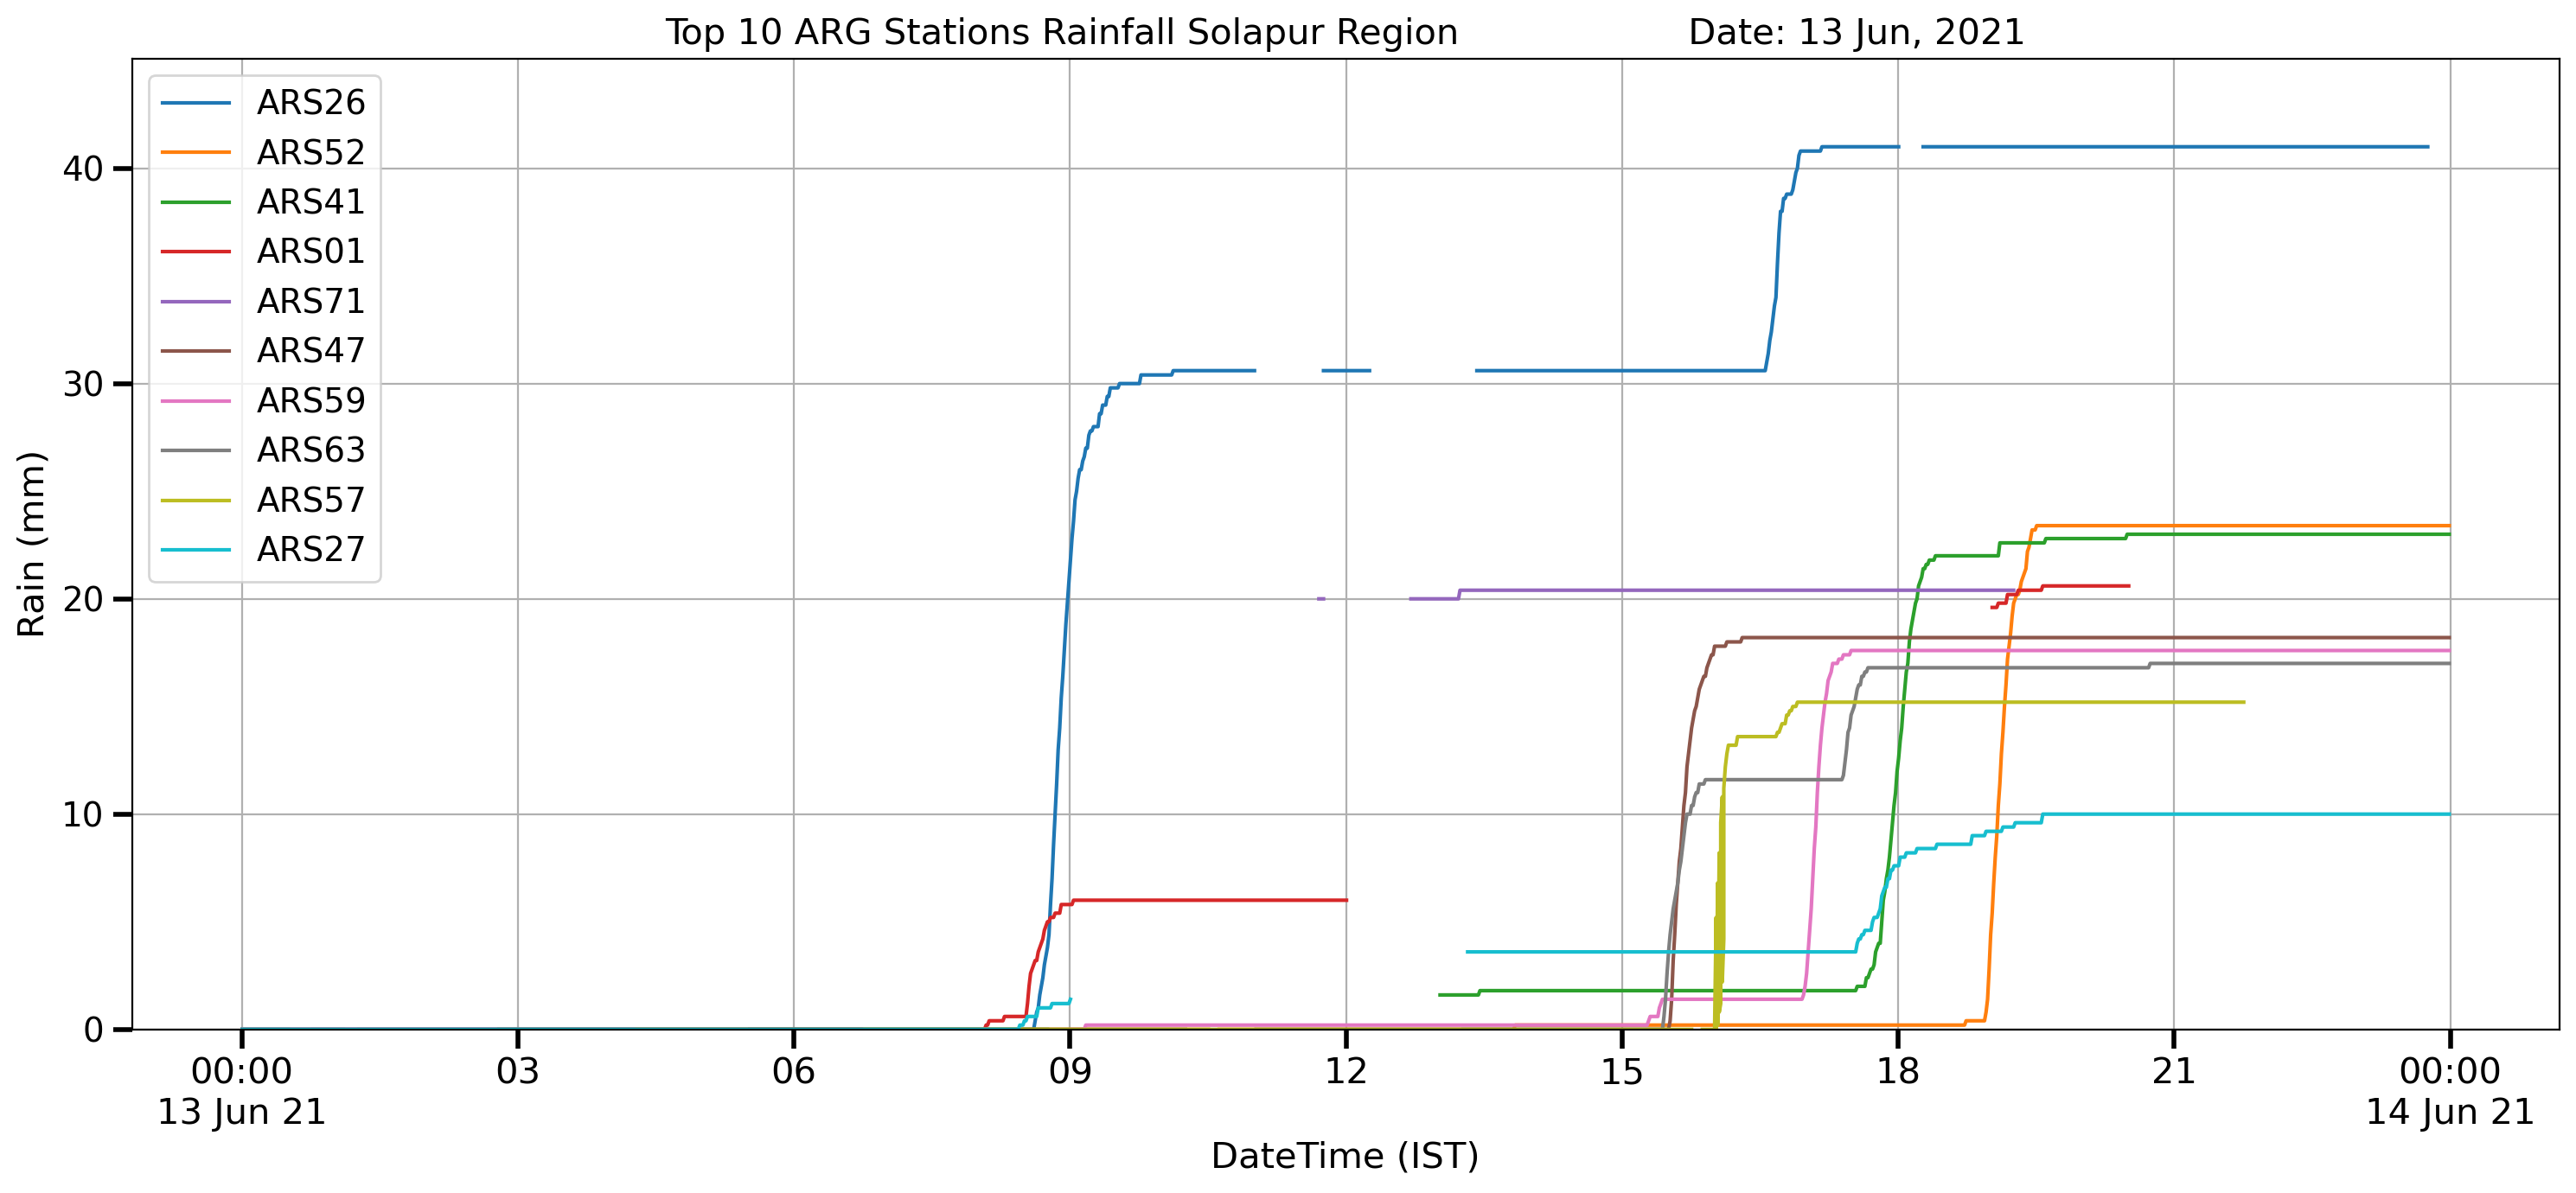

In [20]:
## plot top 10 ARG ##
fig=plt.figure(figsize=[15,7],dpi=200)
for x in range(len(active_rg[:10])):
    plt.plot(vars()[active_rg[x]]['Date'],vars()[active_rg[x]]['Rain_mm'],label=active_rg[x].split('_')[0])
    plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d %b %y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_minor_locator(HourLocator(np.arange(0, 25, 3)))
plt.gca().xaxis.set_minor_formatter(DateFormatter('%H'))
plt.tick_params(axis='both', which='major', labelsize=15,direction='out',length=8, width=2)
plt.tick_params(axis='both', which='minor', labelsize=15,direction='out',length=8, width=2)

plt.ylabel('Rain (mm)',fontsize=15)
plt.xlabel('DateTime (IST)',fontsize=15)
plt.title('Top 10 ARG Stations Rainfall Solapur Region'+'  '*10+'Date: '+vars()[active_rg[0]]['Date'][0].strftime('%d %b, %Y'),fontsize=15)
plt.legend(loc='upper left',fontsize=14)
plt.xticks(fontsize=15);plt.yticks(fontsize=14)
plt.ylim(0,max(max_rf)*1.1)
plt.tight_layout();plt.grid(which='both')
# ax.xaxis.grid(True, which='minor')
plt.savefig('/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/ARG_Plots/'+vars()[active_rg[0]]['Date'][0].strftime('ARG_SLP_Top10ARG_Rf_%d%m%Y.jpg'),bbox_inches="tight",dpi=150)

In [21]:
pos_df=pd.read_csv('/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/SLP_ARG_lat_long.csv')
pos_df['max_rf']=max_rf
pos_df=pos_df.dropna()
pos_df=pos_df.sort_values(by=['max_rf'],ascending=False)

# Geopandas

<Figure size 1500x1050 with 0 Axes>

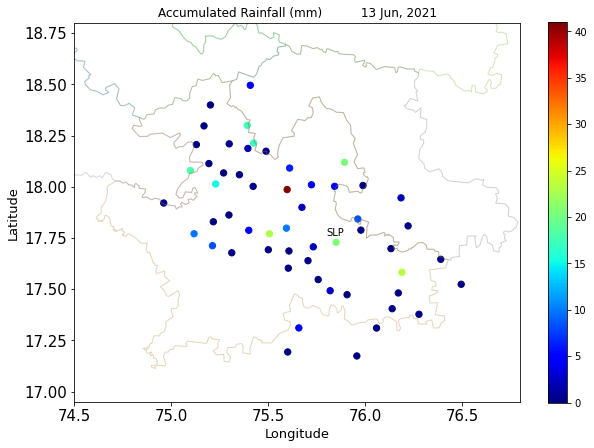

In [24]:
fp = '/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/SHAPEFILES/maharashtra_administrative/maharashtra_administrative.shp'
map_df = gpd.read_file(fp)
map_df.head()

fig=plt.figure(figsize=[10,7],dpi=150)
map_df.iloc[[17,11,41,39,45],:].plot(figsize=[10,7],cmap='Dark2',linewidth=1,alpha=0.3)
plt.scatter(pos_df['long'],pos_df['lat'],c=pos_df['max_rf'],vmin=0,vmax=max(max_rf),cmap='jet',s=40)
plt.colorbar()
# plt.plot(75.850609,17.729193,'ko',markersize=15,alpha=0.2,label='Solapur Lab')
plt.xlabel('Longitude',fontsize=13)
plt.ylabel('Latitude',fontsize=13)
plt.xlim(74.5,76.8)
plt.ylim(16.95,18.8)
plt.text(75.80,17.76,'SLP')
plt.xticks(fontsize=15);plt.yticks(fontsize=15)
plt.title('Accumulated Rainfall (mm)'+'  '*5+vars()[active_rg[0]]['Date'][0].strftime('%d %b, %Y'),fontsize=12)
plt.savefig('/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/ARG_Plots/'+
            vars()[active_rg[0]]['Date'][0].strftime('ARG_SLP_AccRf_%d%m%Y.jpg'),bbox_inches="tight",dpi=300)

# Shapefile

In [25]:
# shp_path = '/home/PDTC/PDTCCAIPEEX/jrao/Data/IMRAN/ARS/SHAPEFILES/maharashtra_administrative/maharashtra_administrative.shp'
# sf = shp.Reader(shp_path)

# def read_shapefile(sf):
#     #fetching the headings from the shape file
#     fields = [x[0] for x in sf.fields][1:]
# #fetching the records from the shape file
#     records = [list(i) for i in sf.records()]
#     shps = [s.points for s in sf.shapes()]
# #converting shapefile data into pandas dataframe
#     df = pd.DataFrame(columns=fields, data=records)
# #assigning the coordinates
#     df = df.assign(coords=shps)
#     return df

# df = read_shapefile(sf)

# def plot_shape(id, s=None):
#     fig=plt.figure(figsize=[10,7],dpi=150)
#     #plotting the graphical axes where map ploting will be done
#     ax = plt.axes()
#     ax.set_aspect('equal')
# #storing the id number to be worked upon
#     shape_ex = sf.shape(id)
# #NP.ZERO initializes an array of rows and column with 0 in place of each elements 
#     #an array will be generated where number of rows will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
#     x_lon = np.zeros((len(shape_ex.points),1))
# #an array will be generated where number of rows will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
#     y_lat = np.zeros((len(shape_ex.points),1))
#     for ip in range(len(shape_ex.points)):
#         x_lon[ip] = shape_ex.points[ip][0]
#         y_lat[ip] = shape_ex.points[ip][1]
# #plotting using the derived coordinated stored in array created by numpy
#     plt.plot(x_lon,y_lat,color='k') 
#     x0 = np.mean(x_lon)
#     y0 = np.mean(y_lat)
#     plt.text(x0, y0, s, fontsize=10)
# # use bbox (bounding box) to set plot limits
#     plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
#     return x0, y0

# fig=plt.figure(figsize=[10,7],dpi=150)
# plot_shape(39,' ')
# plt.scatter(pos_df['long'],pos_df['lat'],c=pos_df['max_rf'],vmin=0,vmax=max(max_rf),cmap='jet',s=40)
# plt.colorbar()
# plt.plot(75.850609,17.729193,'ko',markersize=15,alpha=0.2,label='Solapur Lab')
# plt.legend(fontsize=8)
# plt.xlabel('Longitude',fontsize=13)
# plt.ylabel('Latitude',fontsize=13)
# plt.xlim(74.5,76.8)
# plt.ylim(16.95,18.8)
# plt.title('Accumulated rainfall '+'  '*5+vars()[active_rg[0]]['Date'][0].strftime('%d %b, %Y'),fontsize=12)
# # plt.savefig('D:/DATA/ARG/Plots/'+vars()[active_rg[0]]['Date'][0].strftime('ARG_SLP_AccRf_%d%m%Y.png'),bbox_inches="tight",dpi=200)